# Running Tensor-cell2cell on your own GPU or on Google Colab's GPU

You can run this notebook locally or on [Google Colab directly here](https://colab.research.google.com/drive/1T6MUoxafTHYhjvenDbEtQoveIlHT2U6_?usp=sharing)

**Before running this notebook**, make sure to have a proper NVIDIA GPU driver (https://www.nvidia.com/Download/index.aspx) as well as the CUDA toolkit (https://developer.nvidia.com/cuda-toolkit) installed.

Then, make sure to create an environment with [Pytorch following these instructions to enable CUDA](https://pytorch.org/get-started/locally/)

## Citations

If you plan using this notebook with your own scRNA-seq data, please cite these references:

- **Tensor-cell2cell Tool**: Armingol E., Baghdassarian H., Martino C., Perez-Lopez A., Aamodt C., Knight R., Lewis N.E. Context-aware deconvolution of cell-cell communication with Tensor-cell2cell. Nat Commun 13, 3665 (2022). https://doi.org/10.1038/s41467-022-31369-2
- **Repository of Ligand-Receptor Pairs used to download the list of LR pairs**: Armingol, E., Officer, A., Harismendy, O. et al. Deciphering cell–cell interactions and communication from gene expression. Nat Rev Genet 22, 71–88 (2021). https://doi.org/10.1038/s41576-020-00292-x
- **List of Ligand-Receptor Pairs**: Jin, S., Guerrero-Juarez, C.F., Zhang, L. et al. Inference and analysis of cell-cell communication using CellChat. Nat Commun 12, 1088 (2021). https://doi.org/10.1038/s41467-021-21246-9

## Initial setups

### Installing necessary libraries

In [1]:
# To install a stable version of cell2cell run this:
#!pip install cell2cell

### Loading libraries


In [3]:
import cell2cell as c2c
import scanpy as sc

import pandas as pd
import numpy as np

from tqdm import tqdm

%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
c2c.__version__

'0.6.4'

## Load Data

### Directories to store data

In [6]:
output_folder = './BALF-COVID19/'
c2c.io.directories.create_directory(output_folder)

./BALF-COVID19/ already exists.


### Example dataset of COVID-19

This is a BALF COVID-19 dataset that consists in 63k immune and epithelial cells in lungs from 3 control, 3 moderate COVID-19, and 6 severe COVID-19 patients.

This dataset was previously published in [1], and this object contains the raw counts for the annotated cell types available in: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926

Here we obtain an AnnData object containing the raw counts.

**References:**

[1] Liao, M., Liu, Y., Yuan, J. et al. Single-cell landscape of bronchoalveolar immune cells in patients with COVID-19. Nat Med 26, 842–844 (2020). https://doi.org/10.1038/s41591-020-0901-9

In [7]:
adata = c2c.datasets.balf_covid()

In [8]:
adata

AnnData object with n_obs × n_vars = 63103 × 33538
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition'

### Ligand-Receptor pairs

Different databases of ligand-receptor interactions could be used. We previously created a repository that includes many available DBs (https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs). In this tutorial, we employ the ligand-receptor pairs from CellChat (https://doi.org/10.1038/s41467-021-21246-9), which includes multimeric protein complexes.

In [9]:
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
lr_pairs = lr_pairs.astype(str)

In [10]:
lr_pairs.head(2)

,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,ligand_symbol,receptor_symbol,ligand_ensembl,receptor_ensembl,interaction_symbol,interaction_ensembl
0,TGFB1_TGFBR1_TGFBR2,TGFb,TGFB1,TGFbR1_R2,TGFb agonist,TGFb antagonist,nan,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB1 - (TGFBR1+TGFBR2),TGFB1,TGFBR1&TGFBR2,ENSG00000105329,ENSG00000106799&ENSG00000163513,TGFB1^TGFBR1&TGFBR2,ENSG00000105329^ENSG00000106799&ENSG00000163513
1,TGFB2_TGFBR1_TGFBR2,TGFb,TGFB2,TGFbR1_R2,TGFb agonist,TGFb antagonist,nan,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB2 - (TGFBR1+TGFBR2),TGFB2,TGFBR1&TGFBR2,ENSG00000092969,ENSG00000106799&ENSG00000163513,TGFB2^TGFBR1&TGFBR2,ENSG00000092969^ENSG00000106799&ENSG00000163513


**Interaction columns contianing the gene names**

In [11]:
int_columns = ('ligand_symbol', 'receptor_symbol')

## Data Preprocessing

### Information of samples
First, generate a dictionary indicating what condition group is associated to each sample/context

In [12]:
context_dict = adata.obs.set_index('sample')['condition'].sort_values().to_dict()

In [13]:
context_dict

{'C100': 'Control',
 'C52': 'Control',
 'C51': 'Control',
 'C142': 'Moderate COVID-19',
 'C141': 'Moderate COVID-19',
 'C144': 'Moderate COVID-19',
 'C143': 'Severe COVID-19',
 'C148': 'Severe COVID-19',
 'C149': 'Severe COVID-19',
 'C146': 'Severe COVID-19',
 'C145': 'Severe COVID-19',
 'C152': 'Severe COVID-19'}

### Generate list of RNA-seq data (per sample) with single cells aggregated into cell types

Here, we convert the single-cell expression levels into cell-type expression levels. A basic context-wise preprocessing is performed here, keeping only genes that are expressed at least in 4 single cells.

**Important:** A list of aggregated gene expression matrices must be used for building the 4D-communication tensor. Each of the gene expression matrices is for one of the contexts, following the same order as the previous dictionary (context_dict).

Each gene expression is aggregated here across all single cells annotated with the same cell type as the average log1p(CPM) value. Other aggregation methods could be used, please inspect parameter ```method='average'``` in the ```aggregate_single_cell()``` function. Additionally, other gene expression values could be passed, using other preprocessing approaches such as the non-zero fraction of cells expressing a gene or batch correction methods.

In [14]:
rnaseq_matrices = []

# Iteraty by sample/context
for context in tqdm(context_dict.keys()):
    # Obtain metadata for context
    meta_context = adata.obs.loc[adata.obs['sample'] == context].copy()
    # Single cells in the context
    cells = list(meta_context.index)

    # Rename index name to identify the barcodes when aggregating expression
    meta_context.index.name = 'barcode'

    # Subset RNAseq data by the single cells in the sample/context
    tmp_adata = adata[cells]

    # Keep genes in each sample with at least 4 single cells expressing it
    genes = sc.pp.filter_genes(tmp_adata, min_cells=4, inplace=False)[0]
    
    # Convert raw counts into log1p(CPM)
    sc.pp.normalize_total(tmp_adata, target_sum=1e6)
    sc.pp.log1p(tmp_adata)

    # Convert to dataframe and keep filtered genes
    tmp_adata = tmp_adata.to_df().loc[:, genes]

    # Aggregate gene expression of single cells into cell types
    exp_df = c2c.preprocessing.aggregate_single_cells(rnaseq_data=tmp_adata,
                                                      metadata=meta_context,
                                                      barcode_col='barcode',
                                                      celltype_col='celltype',
                                                      method='average',
                                                     )

    rnaseq_matrices.append(exp_df)

100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.23it/s]


### Preprocessing of LR pairs

**Generate a dictionary with function info for each LR pairs.**

Keys are LIGAND_NAME^RECEPTOR_NAME (this is the same nomenclature that will be used when building the 4D-communication tensor later), and values are the function in the annotation column in the dataframe containing ligand-receptor pairs. ***Other functional annotations of the LR pairs could be used if available.***

In [15]:
ppi_functions = dict()

for idx, row in lr_pairs.iterrows():
    ppi_label = row[int_columns[0]] + '^' + row[int_columns[1]]
    ppi_functions[ppi_label] = row['annotation']

## Tensor-cell2cell analysis

Build 4D-Communication Tensor
Here we use as input the list of gene expression matrices that were aggregated into a cell-type granularity. This list contains the expression matrices of all samples/contexts.

The following functions perform all the steps to build a 4D-communication tensor:

![TC2C](https://earmingol.github.io/cell2cell/tutorials/ASD/figures/4d-tensor.png).

The parameter ```communication_score``` indicates the scoring function to use.

```how='inner'``` is used to keep only cell types and genes that are across all contexts. Use ```how='outer'``` to include all cell types, even if they are not in all samples/contexts. When using the last option, a tensor.mask attribute is created, where zeros indicates what are the missing cell pairs and LR interactions in the given contexts, and ones indicate those that are present. Thus, we can deal with missing values by assigning them a value of zero during the tensor decomposition. We can also control the minimum fraction of samples that must containg a LR pair or a cell type to be included in the tensor, through the parameter ```outer_fraction```.

```complex_sep='&'``` is used to specify that the list of ligand-receptor pairs contains protein complexes and that subunits are separated by '&'. If the list does not have complexes, use ```complex_sep=None``` instead.

In [16]:
tensor = c2c.tensor.InteractionTensor(rnaseq_matrices=rnaseq_matrices,
                                      ppi_data=lr_pairs,
                                      context_names=list(context_dict.keys()),
                                      how='outer',
                                      outer_fraction=0.5, # Considers elements in at least 50% of samples
                                      complex_sep='&',
                                      interaction_columns=int_columns,
                                      communication_score='expression_gmean',
                                     )

Getting expression values for protein complexes
Building tensor for the provided context


### Evaluate some tensor properties

**Tensor shape**

This indicates the number of elements in each tensor dimension: (Contexts, LR pairs, Sender cells, Receiver cells)

In [17]:
tensor.tensor.shape

(12, 807, 10, 10)

**Fraction of excluded elements**

This represents the fraction of values that are ignored (masked) in the analysis. 

In [18]:
tensor.excluded_value_fraction()

0.28569496076001655

### Prepare Tensor Metadata

To interpret analysis on the tensor, we can assign groups to each sample/context, and to every elements in the other dimensions (LR pairs and cells).

We can generate respective dictionaries manually or automatically from DBs.

In [19]:
meta_tensor = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, ppi_functions, None, None],
                                                  fill_with_order_elements=True
                                                  )

### Run Tensor-cell2cell

Here we use the ```tf_optimization='regular'```, which is faster but generates less robust results. We recommend using ```tf_optimization='robust```, which takes longer to run.

Running Elbow Analysis


  0%|          | 0/25 [00:00<?, ?it/s]

The rank at the elbow is: 10
Running Tensor Factorization
Generating Outputs
Loadings of the tensor factorization were successfully saved into ./BALF-COVID19//Loadings.xlsx


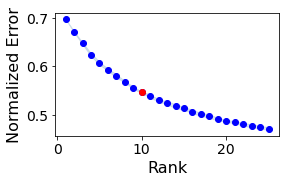

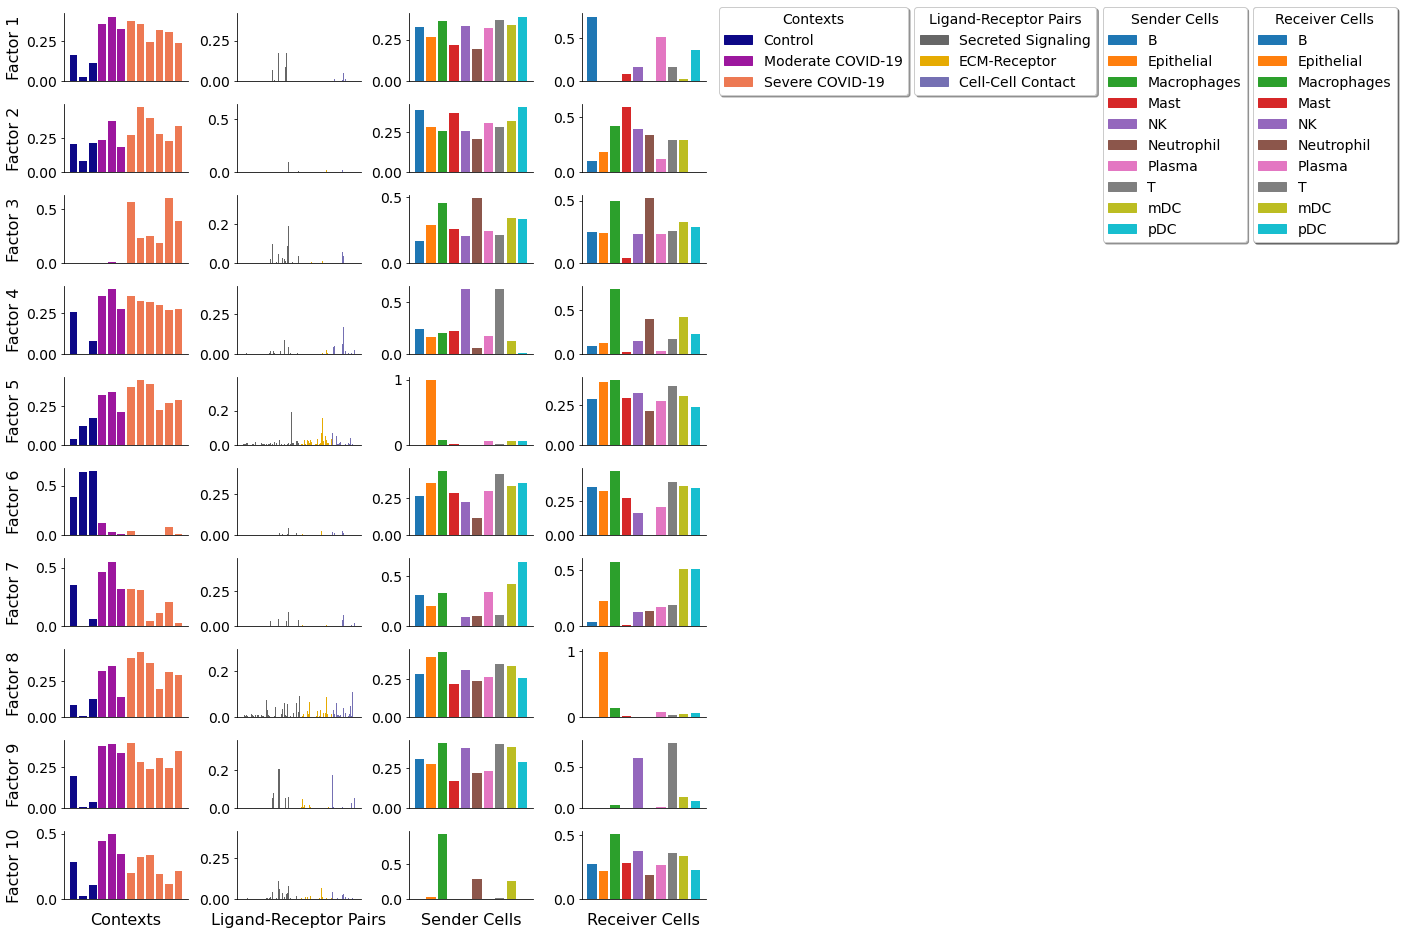

In [20]:
tensor2 = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                     meta_tensor,
                                                     copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                     rank=None, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis
                                                     tf_optimization='regular', # To define how robust we want the analysis to be.
                                                     random_state=888, # Random seed for reproducibility
                                                     backend='pytorch', # This enables a banckend that supports using a GPU.
                                                     device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                     elbow_metric='error', # Metric to use in the elbow analysis.
                                                     smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                     upper_rank=25, # Max number of factors to try in the elbow analysis
                                                     tf_init='random', # Initialization method of the tensor factorization
                                                     tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                     cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                     sample_col='Element', # Columns containing the elements in the tensor metadata
                                                     group_col='Category', # Columns containing the major groups in the tensor metadata
                                                     fig_fontsize=14, # Fontsize of the figures generated
                                                     output_folder=output_folder, # Whether to save the figures and loadings in files. If so, a folder pathname must be passed
                                                     output_fig=True, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                     fig_format='pdf', # File format of the figures.
                                                    )

**Top genes in each factor**

In [21]:
for i in range(tensor2.rank):
    print(tensor2.get_top_factor_elements('Ligand-Receptor Pairs', 'Factor {}'.format(i+1), 10))
    print('')

CD99^CD99             0.396975
MIF^CD74&CXCR4        0.368345
MIF^CD74&CD44         0.348051
LGALS9^PTPRC          0.319667
TNFSF13B^TNFRSF13B    0.244478
LGALS9^CD44           0.239305
APP^CD74              0.226378
SELPLG^SELL           0.223956
PTPRC^CD22            0.206616
CXCL10^CXCR3          0.174164
Name: Factor 1, dtype: float32

MIF^CD74&CD44        0.607854
LGALS9^CD44          0.450888
CD99^CD99            0.402892
LGALS9^PTPRC         0.260705
LGALS9^HAVCR2        0.258238
MIF^CD74&CXCR4       0.166606
APP^CD74             0.142985
COL9A2^CD44          0.112663
CD22^PTPRC           0.103688
NAMPT^ITGA5&ITGB1    0.098853
Name: Factor 2, dtype: float32

CCL8^CCR1            0.328729
SPP1^CD44            0.318466
CCL3L1^CCR1          0.311767
CCL3^CCR1            0.311655
CCL7^CCR1            0.280976
ANXA1^FPR1           0.240010
MIF^CD74&CXCR4       0.191990
NAMPT^ITGA5&ITGB1    0.188227
MIF^CD74&CD44        0.179285
SPP1^ITGA5&ITGB1     0.165535
Name: Factor 3, dtype: flo

## Export objects

Beyond the generated results, we can export the objects here for using them in posterior analyses.

In [22]:
# Export Tensor after decomposition

c2c.io.export_variable_with_pickle(tensor, output_folder + 'Tensor.pkl')

./BALF-COVID19/Tensor.pkl  was correctly saved.


In [23]:
# Export Tensor Metadata

c2c.io.export_variable_with_pickle(meta_tensor, output_folder + 'Tensor-Metadata.pkl')

./BALF-COVID19/Tensor-Metadata.pkl  was correctly saved.
